In [1]:
cd ..

/lus/grand/projects/STlearn/4D_fMRI_Transformer


In [2]:
import pytorch_model_summary
import torch
from modules.model import Encoder_Transformer_Decoder,Encoder_Transformer_finetune,AutoEncoder, MobileNet_v2_Transformer_finetune,MobileNet_v3_Transformer_finetune

In [9]:
import shap

In [3]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from modules.data_preprocess_and_load.data_module3 import fMRIDataModule
import os
def get_arguments(base_path):
    """
    handle arguments from commandline.
    some other hyper parameters can only be changed manually (such as model architecture,dropout,etc)
    notice some arguments are global and take effect for the entire three phase training process, while others are determined per phase
    """
    parser = ArgumentParser(add_help=False, formatter_class=ArgumentDefaultsHelpFormatter)
    parser.add_argument('--exp_name', type=str,default="baseline") 
    parser.add_argument('--base_path', default=base_path)
    parser.add_argument('--step', default='4', choices=['1','2','3','4'], help='which step you want to run')
    
    parser.add_argument('--cuda', default=True)
    parser.add_argument('--log_dir', type=str, default=os.path.join(base_path, 'runs'))
    parser.add_argument('--block_type', default='green', choices=['MobileNet_v2','MobileNet_v3','green'])

    
    
    # parser.add_argument('--random_TR', action='store_false') #True면(인자를 넣어주지 않으면) 전체 sequence 로부터 random sampling(default). False면 (--random_TR 인자를 넣어주면) 0번째 TR부터 sliding window
    
    # loss-related
    parser.add_argument('--intensity_factor', default=1)
    parser.add_argument('--perceptual_factor', default=1)
    parser.add_argument('--which_perceptual', default='vgg', choices=['vgg','densenet3d'])
    parser.add_argument('--reconstruction_factor', default=1)
    
    # model related
    parser.add_argument('--transformer_hidden_layers', type=int,default=16)
    parser.add_argument('--transformer_num_attention_heads',type=int, default=16)
    parser.add_argument('--transformer_emb_size',type=int ,default=2640)
    parser.add_argument('--running_mean_size', default=5000)
    
    # DDP configs:
    parser.add_argument('--world_size', default=-1, type=int, 
                        help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, 
                        help='node rank for distributed training')
    parser.add_argument('--local_rank', default=-1, type=int, 
                        help='local rank for distributed training')
    parser.add_argument('--dist_backend', default='nccl', type=str, 
                        help='distributed backend')
    parser.add_argument('--init_method', default='env', type=str, choices=['file','env'], help='DDP init method')
    parser.add_argument('--distributed', default=False)

    # AMP configs:
    parser.add_argument('--amp', action='store_false')
    parser.add_argument('--gradient_clipping', action='store_true')
    #parser.add_argument('--opt_level', default='O1', type=str,
    #                    help='opt level of amp. O1 is recommended')
    
    # Gradient accumulation
    parser.add_argument("--accumulation_steps", default=1, type=int,required=False,help='mini batch size == accumulation_steps * args.train_batch_size')
    
    # Nsight profiling
    parser.add_argument("--profiling", action='store_true')
    
    # optuna related 
    parser.add_argument('--use_optuna', action='store_true', help='whether to use optuna hyperparameter training. DB location is determined by exp_name')
    parser.add_argument('--use_best_params_from_optuna', action='store_true', help='load best params from Optuna results in DB. --use_optuna should be False if this argument is True')
    parser.add_argument('--num_trials', default=10, help='how many trials')
    parser.add_argument('--n_startup_trials', default=2, help='argument for MedianPruner, Pruning is disabled until the given number of trials finish in the same study.')
    parser.add_argument('--n_warmup_steps', default=5, help='argument for MedianPruner, epoch is same as step in our code. Pruning is disabled until the trial exceeds the given number of step. Note that this feature assumes that step starts at zero.')
    parser.add_argument('--interval_steps', default=1, help='argument for MedianPruner, Interval in number of steps between the pruning checks, offset by the warmup steps. If no value has been reported at the time of a pruning check, that particular check will be postponed until a value is reported.')
    
   
    ##phase 1
    parser.add_argument('--task_phase1', type=str, default='autoencoder_reconstruction')
    parser.add_argument('--batch_size_phase1', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples') #이걸.. 잘게 쪼개볼까? 원래는 4였음.
    parser.add_argument('--validation_frequency_phase1', type=int, default=10000000) # 11 for test #original: 10000) #원래는 1000이었음 -> 약 7분 걸릴 예정.
    parser.add_argument('--nEpochs_phase1', type=int, default=20) #epoch는 10개인 걸로~
    parser.add_argument('--augment_prob_phase1', default=0)
    parser.add_argument('--optim_phase1', default='AdamW')
    parser.add_argument('--weight_decay_phase1', default=1e-7)
    parser.add_argument('--lr_policy_phase1', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase1', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase1', type=float, default=0.97)
    parser.add_argument('--lr_step_phase1', type=int, default=500)
    parser.add_argument('--lr_warmup_phase1', type=int, default=500)

    ##phase 2
    parser.add_argument('--task_phase2', type=str, default='transformer_reconstruction')
    parser.add_argument('--batch_size_phase2', type=int, default=4) #원래는 1이었음
    parser.add_argument('--validation_frequency_phase2', type=int, default=10000000) # 11 for test original: 10000) #원래는 500이었음
    parser.add_argument('--optim_phase2', default='Adam')
    parser.add_argument('--nEpochs_phase2', type=int, default=20)
    parser.add_argument('--augment_prob_phase2', default=0)
    parser.add_argument('--weight_decay_phase2', default=1e-7)
    parser.add_argument('--lr_policy_phase2', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase2', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase2', type=float, default=0.97)
    parser.add_argument('--lr_step_phase2', type=int, default=1000)
    parser.add_argument('--lr_warmup_phase2', type=int, default=500)
    parser.add_argument('--model_weights_path_phase1', default=None)
    parser.add_argument('--use_cont_loss', default=False)
    parser.add_argument('--use_mask_loss', default=False)

    ##phase 3
    parser.add_argument('--task_phase3', type=str, default='fine_tune')
    parser.add_argument('--batch_size_phase3', type=int, default=4) #원래는 3이었음
    parser.add_argument('--validation_frequency_phase3', type=int, default=10000) # 11 for test # original: 10000) #원래는 200이었음
    parser.add_argument('--nEpochs_phase3', type=int, default=20)
    parser.add_argument('--augment_prob_phase3', default=0)
    parser.add_argument('--optim_phase3', default='Adam')
    parser.add_argument('--weight_decay_phase3', default=1e-2)
    parser.add_argument('--lr_policy_phase3', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase3', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase3', type=float, default=0.9)
    parser.add_argument('--lr_step_phase3', type=int, default=1500)
    parser.add_argument('--lr_warmup_phase3', type=int, default=100)
    parser.add_argument('--model_weights_path_phase2', default=None)
    
    ##phase 4 (test)
    parser.add_argument('--task_phase4', type=str, default='test')
    parser.add_argument('--model_weights_path_phase3', default=None)
    parser.add_argument('--batch_size_phase4', type=int, default=4)
    parser.add_argument('--nEpochs_phase4', type=int, default=20)
    parser.add_argument('--augment_prob_phase4', default=0)
    parser.add_argument('--optim_phase4', default='Adam')
    parser.add_argument('--weight_decay_phase4', default=1e-2)
    parser.add_argument('--lr_policy_phase4', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase4', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase4', type=float, default=0.9)
    parser.add_argument('--lr_step_phase4', type=int, default=1500)
    parser.add_argument('--lr_warmup_phase4', type=int, default=100)
    
    temp_args, _ = parser.parse_known_args()
    
    # Set dataset-specific Arguments
    Dataset = fMRIDataModule
    
    parser = Dataset.add_data_specific_args(parser)
    args = parser.parse_args(args=[])
    return args

In [4]:
from modules.utils import *
import time
from modules.utils import *
from modules.trainer import Trainer

base_path = os.getcwd() 

args = get_arguments(base_path)
args.image_path = '/lus/grand/projects/STlearn/HCP_MNI_to_TRs'
args.experiment_folder = '/lus/grand/projects/STlearn/4D_fMRI_Transformer/experiments/S1200_fine_tune_binary_classification_sex_from_scratch_split_1'
args.experiment_title = args.experiment_folder
args.return_value = True
args = sort_args('4', vars(args))

kwargs = args

S = 'test'
trainer = Trainer(sets=S,**kwargs)

#trainer.train_loader.dataset.dataset[0]

loading split file : /lus/grand/projects/STlearn/4D_fMRI_Transformer/data/splits/S1200/split_fixed_1.txt
length of train_idx: 44700
length of val_idx: 9546
length of test_idx: 9676
return_value: True
loading checkpoint from /lus/grand/projects/STlearn/4D_fMRI_Transformer/experiments/S1200_fine_tune_binary_classification_sex_from_scratch_split_1/S1200_fine_tune_binary_classification_sex_from_scratch_split_1_epoch_7_batch_index_279_BEST_val_accuracy.pth
loading parameters onto new model...
notice: named parameter - transformer.cls_embedding.0.weight is randomly initialized
notice: named parameter - transformer.cls_embedding.0.bias is randomly initialized


/home/stella/.conda/envs/3DCNN/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training start from epoch 8 and learning rate 9e-05.
notice: changed layers in perceptual back to old version
using binary_classification loss


In [5]:
input_tensor = trainer.test_loader.dataset.dataset[0]['fmri_sequence'].unsqueeze(0).float()
trainer.model(input_tensor)

tensor([[-7.2849]], grad_fn=<AddmmBackward0>)

In [6]:
model = trainer.model

In [36]:
for name, module in model.named_modules():
    print(name)


encoder
encoder.down_block1
encoder.down_block1.conv0
encoder.down_block1.sp_drop0
encoder.down_block1.green0
encoder.down_block1.green0.block
encoder.down_block1.green0.block.group_norm0
encoder.down_block1.green0.block.relu0
encoder.down_block1.green0.block.conv0
encoder.down_block1.green0.block.group_norm1
encoder.down_block1.green0.block.relu1
encoder.down_block1.green0.block.conv2
encoder.down_block1.downsize_0
encoder.down_block2
encoder.down_block2.green10
encoder.down_block2.green10.block
encoder.down_block2.green10.block.group_norm0
encoder.down_block2.green10.block.relu0
encoder.down_block2.green10.block.conv0
encoder.down_block2.green10.block.group_norm1
encoder.down_block2.green10.block.relu1
encoder.down_block2.green10.block.conv2
encoder.down_block2.green11
encoder.down_block2.green11.block
encoder.down_block2.green11.block.group_norm0
encoder.down_block2.green11.block.relu0
encoder.down_block2.green11.block.conv0
encoder.down_block2.green11.block.group_norm1
encoder.dow

In [19]:
# Fits the explainer
explainer = shap.DeepExplainer(model, input_tensor)

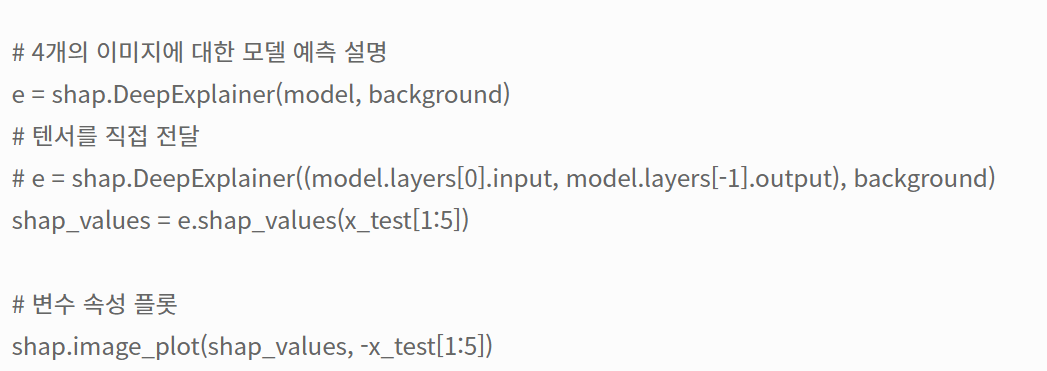

In [53]:
explainer = shap.DeepExplainer(model, input_tensor)

In [54]:
# Calculates the SHAP values - It takes some time
shap_values = explainer.shap_values(input_tensor)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [55]:
shap_values.shape

(1, 1, 96, 96, 96, 20)

In [68]:
shap_values[:, 0, :, :, 0 ,0].shape

(1, 96, 96)

Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.


AssertionError: # weights must match data matrix!

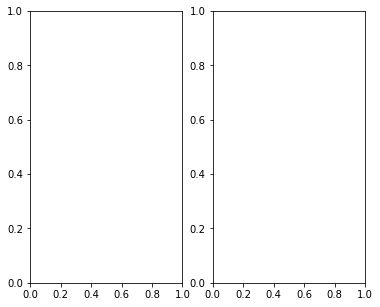

In [66]:
shap.image_plot(shap_values[:, 0, :, :, 0 ,0], -input_tensor.numpy()[:, 0, :, :, 0 ,0]) # (1, 96, 96, 96, 20) -> 2차원